# Part 3: Normalizing Flows and Flow Matching models.

In this part of the homework your goal is to code and train Continuous Normalizing Flow and Conditional Flow Matching models on toy and real data setups (MNIST). We provide a guided code to give you hints about how to address the problems; however, feel free to solve the problem using a different pipeline. 

### Part 3.1. Continuous Normalizing Flows (CNF) (Total points: 9)

In this task you have to train a [CNF](https://arxiv.org/pdf/1806.07366). It will be trained using the Moons dataset from ```scikit-learn```.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Literal, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.distributions.normal import Normal
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint, odeint_adjoint
import torch
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchdyn.core import NeuralODE
from sklearn.datasets import make_moons
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

if torch.cuda.is_available():
    DEVICE = "cuda:1"
    print("GPU found :)")
else:
    DEVICE = "cpu"
    print("GPU not found :(")

GPU found :)


In [ ]:
def plot_moons(X, y=None):
    plt.figure(figsize=(6, 6))

    if y is not None:
        plt.scatter(X[y == 0, 0], X[y == 0, 1], color="skyblue", label="Class 0")
        plt.scatter(X[y == 1, 0], X[y == 1, 1], color="salmon", label="Class 1")
        plt.title("Moons dataset")
        plt.legend()

    else:
        plt.scatter(X[:, 0], X[:, 1], color="salmon")
        plt.title("Generated samples")

    plt.axis("equal")
    plt.show()

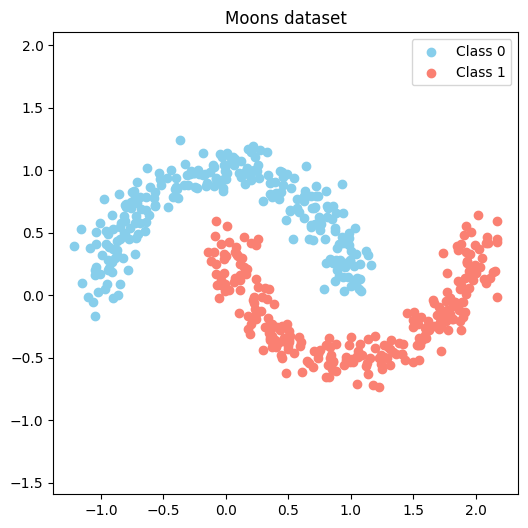

In [6]:
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
plot_moons(X, y)

### Short recap.
Both Normalizing Flows (NF) and Continuous Normalizing Flows (CNF) transform a simple base distribution (e.g., Gaussian) into a complex target distribution via **invertible, differentiable mappings**:

- Given $z \sim p_Z(z)$, apply $x = f_\theta(z)$
- The density of $x$ is computed using:
  $$p_X(x) = p_Z(z) \left| \det \frac{\partial f_\theta}{\partial z} \right|^{-1}$$
- **Key requirement**: $f_\theta$ must be invertible with tractable Jacobian determinant

### Normalizing Flows (NF)
- **Discrete transformations**:  
  $$x = f_K \circ f_{K-1} \circ \cdots \circ f_1(z)$$  
  Each $f_k$ must be invertible (e.g., affine coupling layers)

- **Log-density transformation**:  
  $$\log p_X(x) = \log p_Z(z) - \sum_{k=1}^K \log \left| \det \frac{\partial f_k}{\partial z_{k-1}} \right|$$

---

### Continuous Normalizing Flows (CNF)
- **Continuous transformations** (ODE-defined):  
  $$\frac{dz(t)}{dt} = g_\theta(z(t), t), \quad z(0) \sim p_Z, \quad x = z(T)$$  
  where $g_\theta$ is a neural network. Invertible via ODE reversal

- **Log-density evolution**:  
  $$\frac{d}{dt} \log p(z(t)) = -\text{tr}\left( \frac{\partial g_\theta}{\partial z(t)} \right)$$  
  (Trace approximated efficiently, e.g., Hutchinson's estimator)

---
**Your Task:**

In this task you will implement the CNF approach. In CNF you need to perform the maximum log-likelihood estimation for the transformed samples; therefore your loss function will be given by:

$$
\mathcal{L}(\theta) = -\log p_X(x) = -\log p_Z(z(0)) + \int_0^T \text{tr}\left( \frac{\partial g_\theta(z(t), t)}{\partial z(t)} \right) dt
$$

**Where:**
- $ z(0) $ is the latent variable obtained by solving the ODE backward from $z(T) = x $
- $ p_Z $ is the base distribution (e.g., standard Gaussian)
- $ g_\theta(z(t), t) $ is the neural ODE velocity field
In order to get the full amount of points you should successfully code the following:

The distribution of points is as follows:

1. Vector Field (2 points).
2. CNF class (4 points).
   - ODE function.
   - Forward pass.
   - Sampling.
   - Loss function.
3. Training loop and plotting of predictions/losses (2 points).
4. Trajectories plot. (1 point)

Feel free to choose/use your own architecture, the code snippets below are only provided for guidance.

**Hint:** For this implementation it is better to use ```torchdiffeq``` library to simplify the implementation.


### Part 3.1.1. Implementation of a vector field (2 points)

In [5]:

# We advice to use a vector field with residual connections to get the expected results, but feel free to choose your own type of model
class ResidualBlock(nn.Module):
    
    def __init__(self, dim: int):
        super().__init__()
        self.block = #Your code here
        self.activation = #Your code here

    def forward(self, x):
        return self.activation(x + self.block(x))
        
class VectorField(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, num_blocks: int = 3):
        super().__init__()
        self.input_layer = #Your code here
        self.res_blocks = #Your code here
        self.output_layer = #Your code here

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:

        x_and_t = torch.cat([x, t], dim=1)

        #Your code here
        
        return self.output_layer(h)



### Part 3.1.2. Implementation of CNF class (4 points)

In [ ]:
class CNFModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, device='cuda:0'):
        super().__init__()
        self.input_dim = #Your code here
        self.model     = #Your code here
        self.device    = #Your code here
        self.prior     = #Your code here

    #Define the ODE function that will be input to the ODE solver (1 point)
    def odefunc(self, t, states):
        z, _ = states
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            dz_dt = #Your code here
            trace = #Your code here
            #Your code here
        return dz_dt, -trace

    def forward(self, x, t):
        x     = x.to(self.device)
        dz_dt = torch.zeros([x.shape[0], 1], device=self.device)

        #Solutions of the ODE at different time steps
        states        = #Your code here
            
        #Your code here

        return z, dz_dt

    def loss(self, x) -> Dict[str, torch.Tensor]:
        #Define points in which yo want to solve the ODE
        t        = #Your code here
        z, dz_dt = #Your code here

        logpz = #Your code here
        logpx = #Your code here
        loss  = #Your code here

        return loss

    #This sampling is based in the use of torchdiffeq
    @torch.no_grad()
    def sample(self, z, n_time_steps=10) -> np.ndarray:

            t    = #Your code here
            x, _ = #Your code here
        
            return x.cpu().numpy()

### Part 3.1.3. Implementation of the training loop and visualization (2 points)

**Note:** It is not necessary to plot the trajectories during training, but they are requested in your final plot, so keep that in mind while coding the plotting function.

In [93]:
def plot_moons_losses(x, losses):
    #Your code here

def train_cnf(cnf, lr, n_epochs, batch_size, device):
    
    optimizer = #Your code here
    losses = []
    for i in tqdm(range(n_epochs)):
        cnf.train()
        optimizer.zero_grad()
        x, _ = #Your code here
    
        loss = #Your code here
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('Iter: {}, running avg loss: {:.4f}'.format(i, loss.item()))
            
            cnf.eval()
            with torch.no_grad():
                samples = #Your code here
                plot_moons_loss(samples, losses)
    return losses

In [143]:
batch_size  = #Your code here
input_dim   = #Your code here
hidden_dims = #Your code here
lr          = #Your code here
n_epochs    = #Your code here

cnf_model   = #Your code here

In [ ]:
losses = #Your plot here

### Part 3.1.4. Plotting trajectories (1 point)

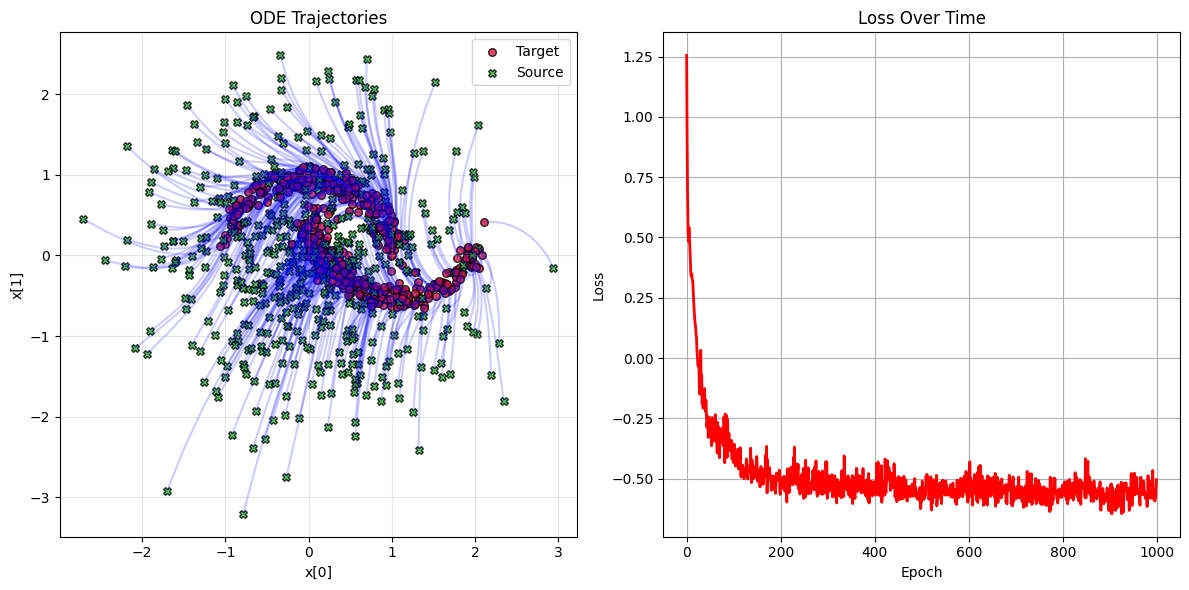

In [54]:
# Please do not remove this code block, you should show your final results here. We provide an expected result.
# Setting test data to see the trajectories, you should use the same for CNF.
z_test = #Your code here
final_samples = #Your code here
#Your code here

## Part 3.2.: Conditional Flow Matching (CFM) (Total points: 7)
Here you will train a [CFM](https://arxiv.org/pdf/2302.00482) model on the Moons dataset again.

### Short recap:

In the previous section we saw that CNF models require to perform sampling from the distribution during training, this is time consuming since it requires to solve an ODE. In order to avoid this increase in training time, CFM proposes a simulation-free approach, which aims to train CNF without the need of sampling. In this task you are asked to implement the [Rectified Flow model](https://arxiv.org/pdf/2209.03003). In this specific setup, the loss to minimize is defined as follows:

$$
\mathcal{L(\theta)}=\min_v \int_0^1 \mathbb{E} \left[ \| (x_1 - x_0) - v_{\theta}(x_t, t) \|^2 \right] dt, \quad \text{with} \quad x_t = tx_1 + (1 - t)x_0. \tag{1}$$

where $x_0, x_1$ are independent samples drawn from source and target distributions, respectively. $x_t$ is an interpolation point and $v_{\theta}$ is a vector field parameterized with neural networks. 

---
**Your Task:**

1. Vector field and CFMModel class (4 points in total).
   - Define your vector field (you may use the previous one with slight changes if needed).
   - Computation of interpolation point $x_t$.
   - Loss function.
   - Sampling method.
2. Training loop and plotting (2 points).
3. Trajectories plot. (1 point).

Feel free to choose/use your own architecture, the code snippets below are only provided for guidance.

### Part 3.2.1. Define your Vector Field as part of the CFMModel class (4 points)

In [ ]:
import torchdyn
from torchdyn.core import NeuralODE

#If you are using residual connections, it should be the same as before, just placed here for convenience
class ResidualBlock(nn.Module):
    
    def __init__(self, dim: int):
        super().__init__()
        self.block = #Your code here
        self.activation = #Your code here

    def forward(self, x):
        return self.activation(x + self.block(x))


class CFMModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, num_blocks: int = 3, device='cuda:1'):
        super().__init__()
        self.input_layer  = #Your code here
        self.res_blocks   = #Your code here
        self.output_layer = #Your code here
        self.device       = device
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
    
        h = #Your code here
        h = #Your code here
        return self.output_layer(h)

    #Define interpolation function (1 point)
    def compute_xt(self, x, y, t, sigma):
        t       = #Your code here
        return #Your code here

    #Define function for the prediction u_t (1 point)
    def compute_ut(self, x, y):
        return #Your code here

    #Define the sampling procedure (1 point)
    @torch.no_grad()
    def sample(self, z, plot_trajectories=False):
        # This sampling is based in the use of Torchdyn
        node = #Your code here
        traj = #Your code here
        samples = #Your code here
        return samples


### Part 3.2.2. Define the training loop for independent plans (2 points)

In [136]:

    
def train_fm(fm, lr, n_epochs, batch_size, device):
    optimizer = #Your code here
    losses = []
    for i in tqdm(range(n_epochs)):
        fm.train()
        optimizer.zero_grad()
        x    = #Your code here
        y, _ = #Your code here

        t  = #Your code here
        xt = #Your code here
        ut = #Your code here

        #Remember to be careful with the dimension of t
        #Your code here
        
        xt = torch.cat([xt, t], dim=1)
        
        vt   = #Your code here
        loss = #Your code here
        
        #loss = fm.loss(x, y) 
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if i % 5000 == 0:
            print('Iter: {}, running avg loss: {:.4f}'.format(i, loss.item()))
            fm.eval()
            with torch.no_grad():

                samples = #Your code here
                plot_moons_loss(samples, losses)
    return losses

In [139]:
batch_size  = #Your code here
input_dim   = #Your code here
hidden_dims = #Your code here
lr          = #Your code here
n_epochs    = #Your code here

fm_model = #Your code here

In [ ]:
losses = #Your code here


### Part 3.2.3. Trajectories plot (1 point)

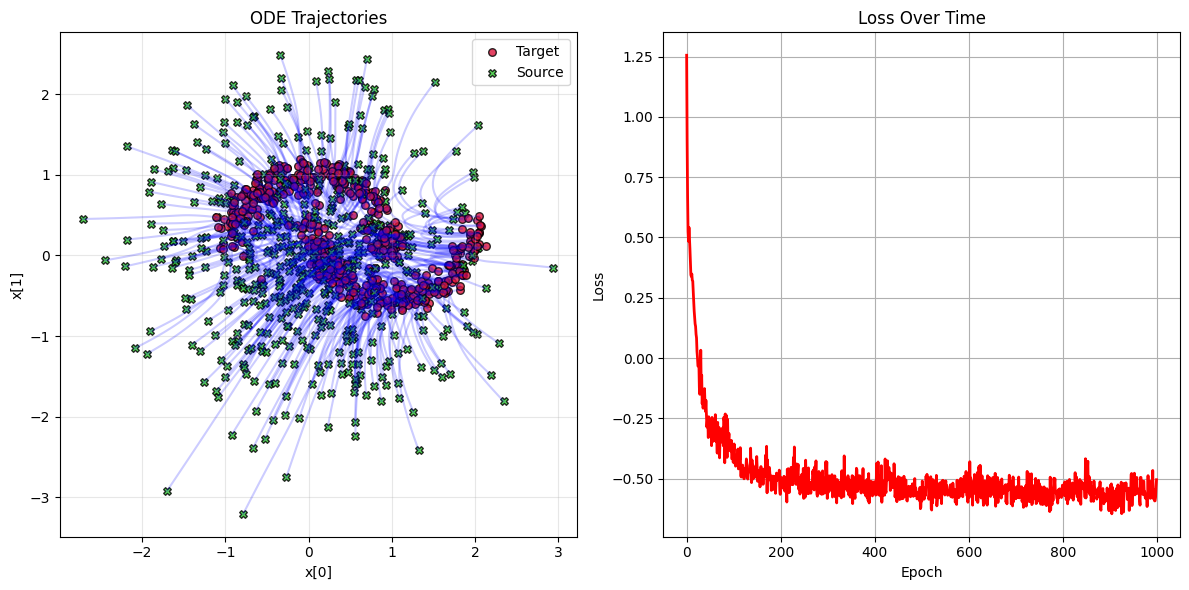

In [55]:
# Please do not remove this code block, you should show your final results here. We provide an expected result.

z_test = #Your code here
final_samples = #Your code here
#Your code here


### Observations: Please share your observations here:

### ...

## 3.3. Conditional Flow Matching on colored MNIST dataset (8 points in total).

In this task you have to train CFM for independent, optimal transport mini-batch plan and optimal transport anti-minibatch plan. 

- Inpendent plan: $x_0$ and $x_1$ are sampled independently.
- OT mini-batch plan: $x_0$ and $x_1$ are optimal transport couples.
- OT ant-minibatch plan: Simila to previous one but for negative cost matrix.

You can check the [Optimal Flow Matching paper](https://arxiv.org/pdf/2403.13117) for further information.

1. Load, preprocess the dataset and visualization (2 points).
2. Vector field for images (It might be convolutional, U-Net, etc.) (2 points).
3. Training loop for different transport plans:
   - Independent plan (as in toy experiment) (1 point)
   - OT minibatch plan (2 points)
   - OT anti-minibatch plan (1 point)

**Hint:** To get good generated images it is strongly advisable to use an ODE solver. Otherwise the quality may be poor. 

**Hint:** It will probably be difficult to get the desire results if you build the network on yor own so it is advisable to look for existing implementations.

### Part 3.3.1. Load dataset, preprocessing and visualization (2 points)

In this task we do not require a validation set since we are not computing any metrics to measure the quality. However, we expect visually good results, you can check our expected results.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, USPS
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_openml
from copy import deepcopy
import numpy as np
import torch
from torch.utils.data import TensorDataset
from typing import Optional, Union, Sequence, Dict, Tuple, List

import torchvision.datasets as TVdatasets
from torchvision import transforms as TVtransforms

In [ ]:
def random_color(im: torch.Tensor) -> torch.Tensor:
    hue = 360 * np.random.rand()
    d = im * (hue % 60) / 60
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    H = round(hue / 60) % 6
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

In [ ]:
class CMNISTDataset(Dataset):
    def __init__(
        self,
        digit: int = 0,
        train: bool = True,
        spat_dim: tuple[int, int] = (16, 16),
        download: bool = False,
        pix_range: tuple[float, float] = (-1.0, 1.0),
    ) -> None:
        # YOUR CODE HERE
        ...

    def __len__(self):
        return  # YOUR CODE HERE

    def __getitem__(self, idx: int) -> torch.Tensor:
        return  # YOUR CODE HERE

In [6]:
SOURCE_DIGIT = 2
TARGET_DIGIT = 3

In [ ]:
source_train = #Your code here
target_train = #Your code here

print(f"Source train: {len(source_train)} images")
print(f"Target train: {len(target_train)} images")


In [8]:
def plot_images(batch, title=None):
    #Your code here

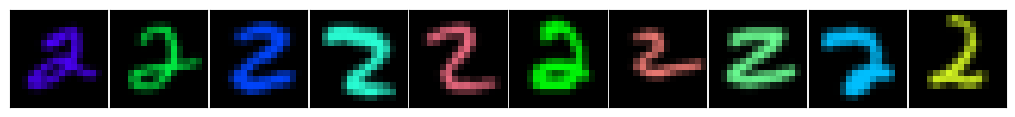

In [9]:
SOURCE_IMAGES = next(iter(DataLoader(source_train, batch_size=10)))
plot_images(SOURCE_IMAGES)

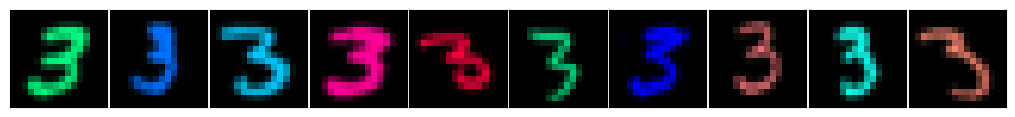

In [10]:
TARGET_IMAGES = next(iter(DataLoader(target_train, batch_size=10)))
plot_images(TARGET_IMAGES)

### Part 3.3.2. Implementation of the model (Conditional Vector Field) (2 points)

In [ ]:

from diffusers import UNet2DModel

class CFMModelMNIST_UNet(nn.Module):
    def __init__(self, image_size=16, device='cuda:1'):
        super().__init__()
        self.device = device
        # Hint: one could use U-net neural network from diffusers
        self.net = #Your code here

    def forward(self, x_t, t):

        ret_val = #Your code here
            
        return #Your code here

    #These two functions should be similar to the previous ones but with some modifications for the image shape
    def compute_xt(self, x, y, t, sigma):
        t = #Your code here
        return #Your code here

        
    def compute_ut(self, x, y):
        return #Your code here

    @torch.no_grad()
    def sample(self, x, t_steps=50, rtol=1e-5, atol=1e-5):
        # Define ODE function 
        def ode_fn(t, x):
            # Convert scalar t to batched tensor input
            t_tensor = #Your code here
            return self.forward(x, t_tensor)

        t_span = #Your code here
        
        # Solve the ODE
        x_traj = #Your code here
        
        return #Your code here  # Return final state at t=1

    

### Part 3.3.3. Implementation of training loop for independent plan (1 point)

In [ ]:

def train_fm_mnist(fm_mnist, source_loader, target_loader, lr, n_epochs, batch_size, device):
    
    optimizer = #Your code here
    
    losses = []
    
    for i in tqdm(range(n_epochs)):
        fm_mnist.train()
        optimizer.zero_grad()
        
        x = #Your code here
        y = #Your code here
    
        t  = #Your code here
        xt = #Your code here
        ut = #Your code here
        vt = #Your code here

        loss = #Your code here
        losses.append(loss.item())

        loss.backward()
        
        optimizer.step()
        
        if i % 1000==0 or i==n_epochs-1:
            
            print('Iter: {}, running avg loss: {:.4f}'.format(i, loss.item()))
            fm_mnist.eval()
            with torch.no_grad():
    
                samples = #Your code here
                plot_images(x_test[:10].cpu())
                plot_images(samples[:10].cpu())
                
                

In [89]:
img_size    = #Your code here
hidden_dims = #Your code here
lr          = #Your code here
n_epochs    = #Your code here
batch_size  = #Your code here

source_cmnist_loader = #Your code here
target_cmnist_loader = #Your code here

fm_model_mnist = #Your code here


In [ ]:
# Your code here

torch.Size([128, 3, 16, 16])
torch.Size([128, 3, 16, 16])


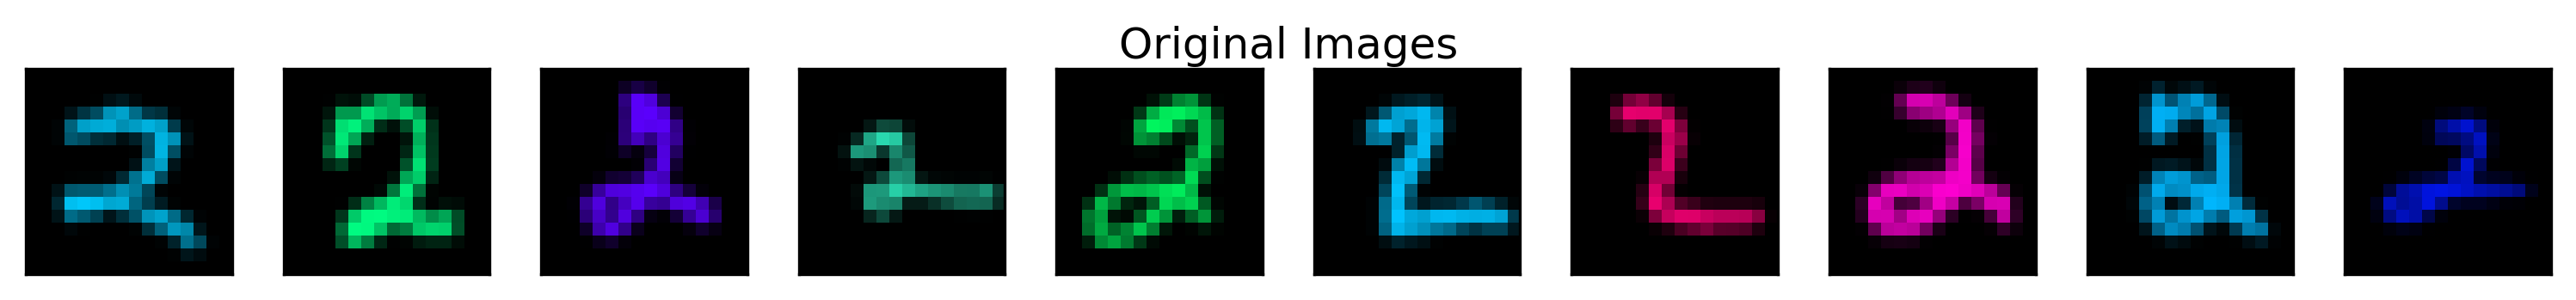

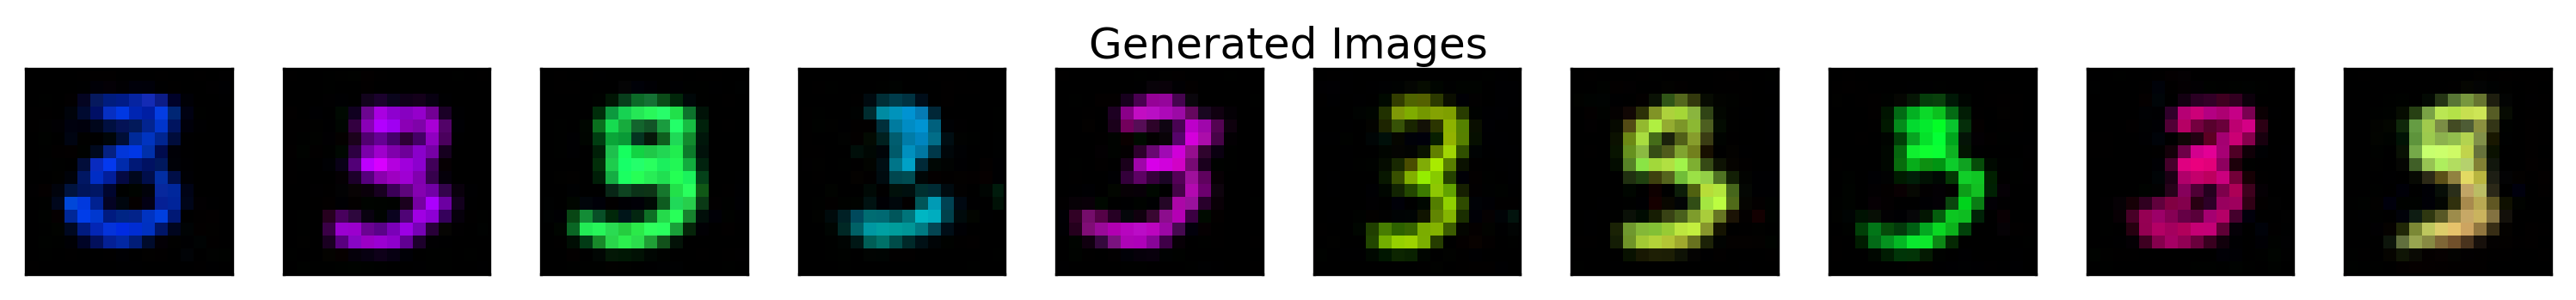

In [ ]:
# Do not remove this cell, show your final results here.

x_test = next(iter(source_cmnist_loader))
x_test = x_test.to(DEVICE)

with torch.no_grad():
    samples = fm_model_mnist.sample(x_test, 200)

print(x_test.shape)
print(samples.shape)

plot_images(x_test[:10].cpu(), "Original Images")
plot_images(samples[:10].cpu(), "Generated Images")

### Part 3.3.4. Implementation of training loop for OT transport plan (2 points)

In these subtasks you have to take the source and target samples by finding the optimal transport couples for each minibatch. You will need to have the Python Optimal Transport (POT) library installed.

In [ ]:
import ot
from functools import partial

#In the next subtask you need to do the anti-minibatch approach, so it is better to code it here as well.
def get_map(x0, x1, antimb=False):

    #Make some reshapes to the data
        
    if antimb:
        M = -torch.cdist(x0, x1) ** 2
    else:
        M = torch.cdist(x0, x1) ** 2
    
    ot_fn = #Your code here
    p = #Your code here

    return p

def sample_map(pi, batch_size):
    p = #Your code here
    choices = #Your code here
    return #Your code here

def sample_plan(x0, x1, antimb=False):
    pi   = #Your code here
    i, j = #Your code here
    return #Your code here

In [ ]:

def train_fm_mnist_ot(fm_mnist, source_loader, target_loader, lr, n_epochs, batch_size, device, antimb=False):

    optimizer = torch.optim.Adam(fm_mnist.parameters(), lr=lr)
    
    losses = []

    
    for i in tqdm(range(n_epochs)):
        fm_mnist.train()
        optimizer.zero_grad()
        
        x = #Your code here
        y = #Your code here

        x, y = sample_plan(x, y, antimb)
        
        t  = #Your code here
        xt = #Your code here
        ut = #Your code here
        vt = #Your code here

        loss = #Your code here
        losses.append(loss.item())

        # Backward pass with clipping
        loss.backward()
        
        # Optimizer step
        optimizer.step()
        
        if i % 1000==0 or i==n_epochs-1:
            
            print('Iter: {}, running avg loss: {:.4f}'.format(i, loss.item()))
            fm_mnist.eval()
            with torch.no_grad():
    
                samples = #Your code here
                plot_images(x_test[:10].cpu())
                plot_images(samples[:10].cpu())
                
                

In [15]:
import ot as pot

img_size    = #Your code here
hidden_dims = #Your code here
lr          = #Your code here
n_epochs    = #Your code here  
batch_size  = #Your code here

source_cmnist_loader = #Your code here
target_cmnist_loader = #Your code here
fm_model_mnist_ot = #Your code here

In [ ]:
# Yoru code here

torch.Size([128, 3, 16, 16])
torch.Size([128, 3, 16, 16])


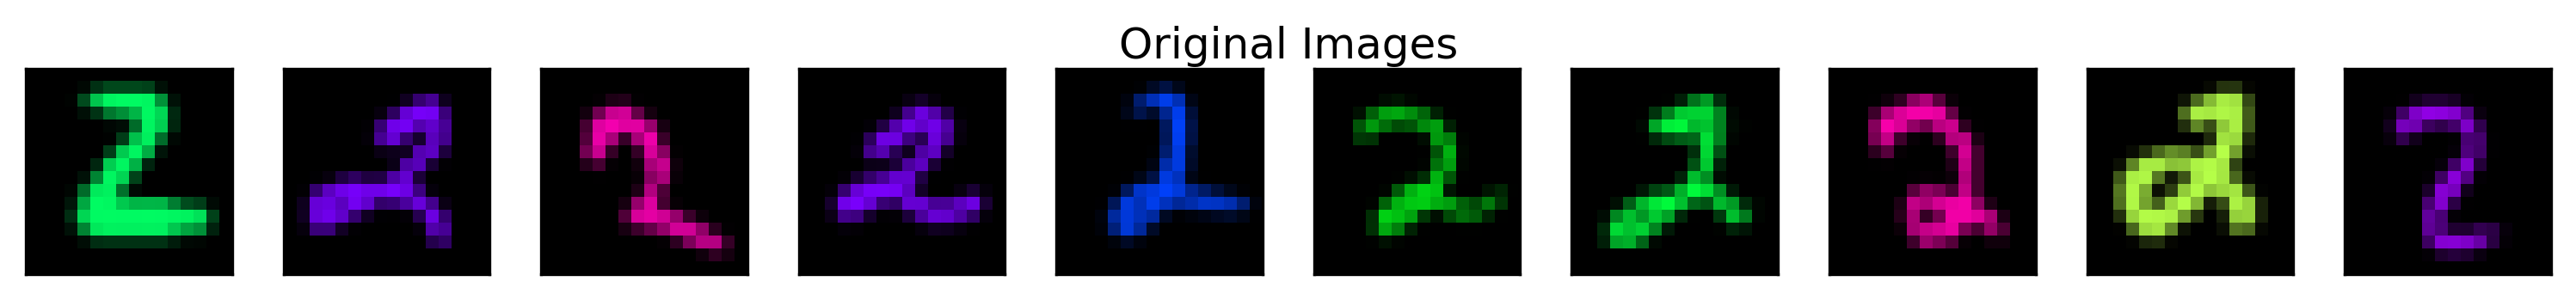

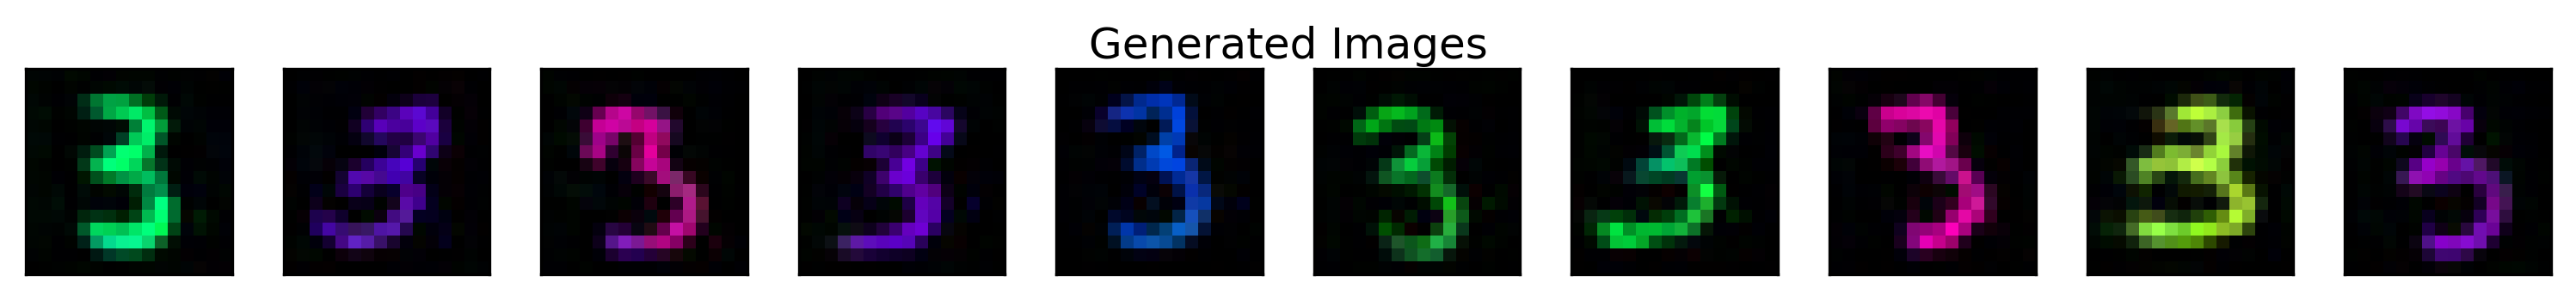

In [ ]:
# Do not remove this cell, show your final results here.

x_test = next(iter(source_cmnist_loader))
x_test = x_test.to(DEVICE)

with torch.no_grad():
    samples = fm_model_mnist_ot.sample(x_test, 200)
print(x_test.shape)
print(samples.shape)
plot_images(x_test[:10].cpu(), "Original Images")
plot_images(samples[:10].cpu(), "Generated Images")

### Part 3.3.4. Implementation of training loop for OT transport plan (anti-minibatch) (1 point)


In [ ]:
# Your code here

torch.Size([128, 3, 16, 16])
torch.Size([128, 3, 16, 16])


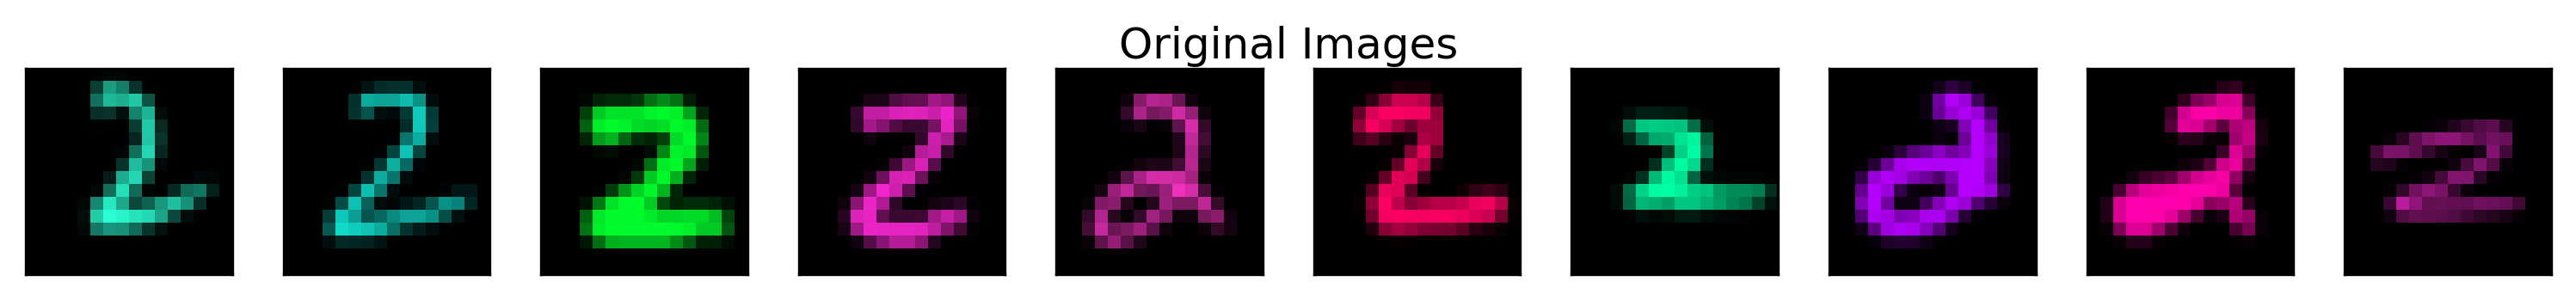

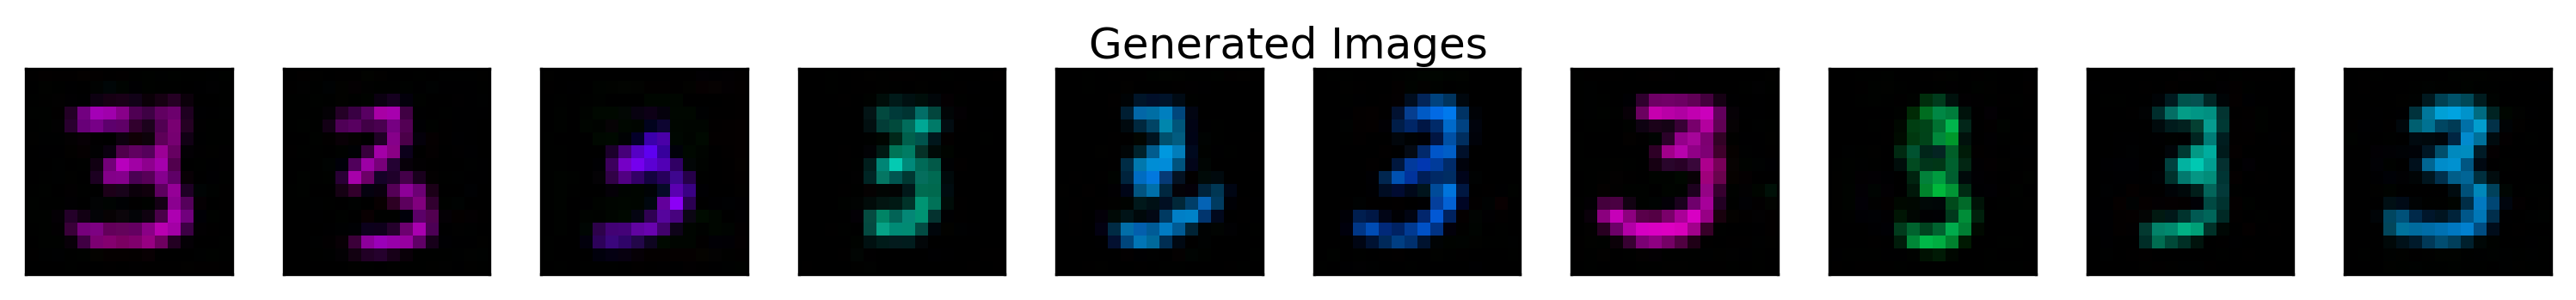

In [ ]:
x_test = next(iter(source_cmnist_loader))
x_test = x_test.to(DEVICE)

with torch.no_grad():
    samples = fm_model_mnist_ot_am.sample(x_test, 200)
print(x_test.shape)
print(samples.shape)
plot_images(x_test[:10].cpu(), "Original Images")
plot_images(samples[:10].cpu(), "Generated Images")

### Observations: Please share your observations here:

### ...